In [9]:
import numpy as np
from os import listdir, path
from PIL import Image, ImageOps
import torch
import torch.utils.data as _data
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import skimage.util

from skimage import data, io, img_as_ubyte
from skimage.filters import threshold_multiotsu
from skimage.color import rgb2gray
from train_dataset import img_patch
from scipy import ndimage
from scipy.interpolate import splprep, splev


In [10]:
img = Image.open('/home/scco0002/F&E_DeepLearning_VS/011_KOVIS_20_03_2023/dataset/dataset_no_rotation/train/picture_1.png')
im_size= [192,192]
img_resized = img_patch(img, im_size)
img_resized = np.array(img_resized) # 8076

In [11]:
img_ski = skimage.util.img_as_float32(img_resized)
img_gray= rgb2gray(img_ski)


# Apply multi-Otsu threshold 
thresholds = threshold_multiotsu(img_gray, classes=3)

# Digitize (segment) original image into multiple classes.
#np.digitize assign values 0, 1, 2, 3, ... to pixels in each class.
regions = np.digitize(img_gray, bins=thresholds)
mask_1 = img_as_ubyte(regions)  #Convert 64 bit integer values to uint8


board_mask = mask_1.copy()
board_mask[board_mask == 0] = 9
board_mask[board_mask == 3] = 0
board_mask[board_mask == 2] = 0
board_mask[board_mask == 1] = 0

# Find the bounding box of the first class
y, x = np.where(board_mask == 9)


# Passe einen B-Spline durch die Punkte
tck, u = splprep([x, y], s=0, per=False)

# Erstelle ein neues Array, das den B-Spline enthält
new_x, new_y = splev(np.linspace(0, 1, 36000), tck)
board_mask = np.zeros_like(board_mask)
board_mask[np.round(new_y).astype(int), np.round(new_x).astype(int)] = 1
board_mask_image = Image.fromarray(board_mask)

plt.imsave("Segmentation_mask_tests/board_mask.jpg", board_mask_image)

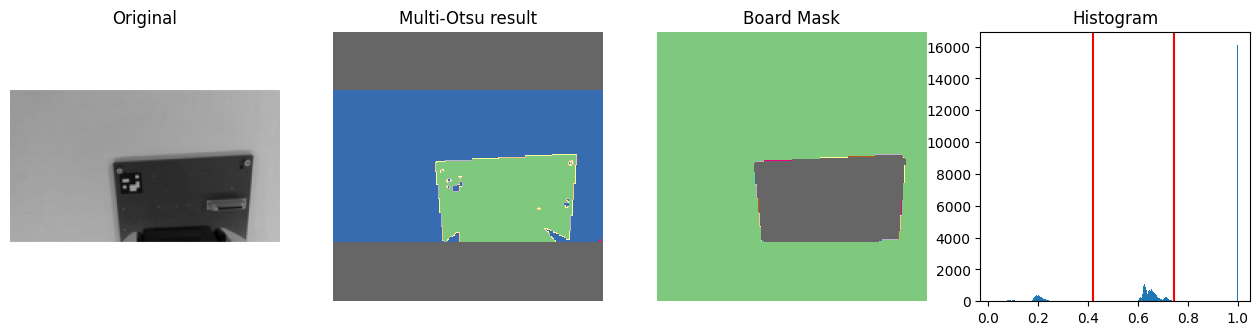

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 3.5))

# Plotting the original image.
ax[0].imshow(img_gray, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the Multi Otsu result.
ax[1].imshow(regions, cmap='Accent')
ax[1].set_title('Multi-Otsu result')
ax[1].axis('off')

# Plotting the Board Mask
ax[2].imshow(board_mask, cmap='Accent')
ax[2].set_title('Board Mask')
ax[2].axis('off')

# Plotting the histogram and the two thresholds obtained from multi-Otsu.
ax[3].hist(img_gray.ravel(), bins=255)
ax[3].set_title('Histogram')
for thresh in thresholds:
    ax[3].axvline(thresh, color='r')

plt.subplots_adjust()
plt.show()

In [13]:
img_gray_board = img_gray.copy()
img_gray_board[board_mask == 0] = 0

# Apply multi-Otsu threshold 
thresholds = threshold_multiotsu(img_gray_board, classes=4)

# Digitize (segment) original image into multiple classes.
#np.digitize assign values 0, 1, 2, 3, ... to pixels in each class.
regions = np.digitize(img_gray_board, bins=thresholds)
mask_2 = img_as_ubyte(regions)  #Convert 64 bit integer values to uint8

plug_mask = mask_2.copy()
plug_mask[plug_mask == 3] = 0
plug_mask[plug_mask == 1] = 0

# 1. Identifizieren Sie die Koordinaten aller 2er-Werte in der Array
coords = np.where(plug_mask == 2)
# 2. Identifizieren Sie die zusammenhängenden Bereiche von 2er-Werten in der Array
labels, num_labels = ndimage.label(plug_mask == 2)
# 3. Zählen Sie die Anzahl der Pixel in jedem identifizierten Bereich
counts = np.bincount(labels.flatten())
# 4. Identifizieren Sie die Nummer des größten Bereichs
largest_label = np.argmax(counts[1:]) + 1
# 5. Bestimmen Sie die Begrenzung des Rechtecks um den größten Bereich
largest_label_mask = (labels == largest_label)
ys, xs = np.where(largest_label_mask)
y_min, y_max, x_min, x_max = ys.min(), ys.max(), xs.min(), xs.max()
# 6. Erstellen Sie eine neue Array mit denselben Dimensionen wie die ursprüngliche Array, aber mit allen 2er-Werten auf 0
plug_mask = np.zeros_like(plug_mask)
# 7. Setzen Sie alle Pixel innerhalb der Begrenzung des Rechtecks auf 2 in der neuen Array
plug_mask[y_min:y_max+1, x_min:x_max+1][largest_label_mask[y_min:y_max+1, x_min:x_max+1]] = 2

idxs = np.where(plug_mask == 2)

# Bestimme die Grenzen der Bounding Box
top = np.min(idxs[0])
left = np.min(idxs[1])
bottom = np.max(idxs[0])
right = np.max(idxs[1])

# Erweitere die Bounding Box um 1 Pixel in alle Richtungen
top = max(0, top - 1)
left = max(0, left - 1)
bottom = min(plug_mask.shape[0] - 1, bottom + 1)
right = min(plug_mask.shape[1] - 1, right + 1)

# Erstelle eine Kopie des Arrays und fülle die Bounding Box mit 2er
#plug_mask = plug_mask.copy()
plug_mask[top:bottom+1, left:right+1][plug_mask[top:bottom+1, left:right+1] == 0] = 2

plug_mask[plug_mask == 2] = 1

plug_mask_image = Image.fromarray(plug_mask)

plt.imsave("Segmentation_mask_tests/plug_mask.jpg", plug_mask_image)

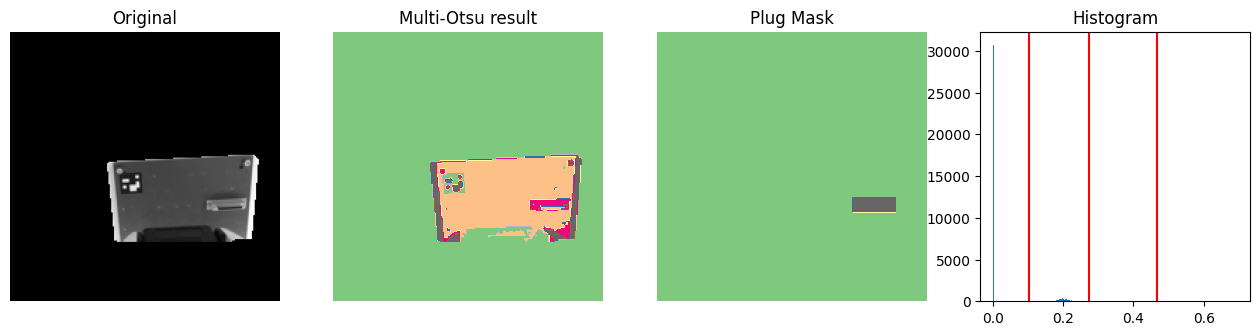

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 3.5))

# Plotting the original image.
ax[0].imshow(img_gray_board, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(regions, cmap='Accent')
ax[1].set_title('Multi-Otsu result')
ax[1].axis('off')


# Plotting the Multi Otsu result.
ax[2].imshow(plug_mask, cmap='Accent')
ax[2].set_title('Plug Mask')
ax[2].axis('off')


# Plotting the histogram and the two thresholds obtained from multi-Otsu.
ax[3].hist(img_gray_board.ravel(), bins=255)
ax[3].set_title('Histogram')
for thresh in thresholds:
    ax[3].axvline(thresh, color='r')

plt.subplots_adjust()
plt.show()